<a href="https://colab.research.google.com/github/WankhedeAmey/Neural-Network-/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import of Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.lib.stride_tricks import sliding_window_view
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

!pip install scikit_optimize # Needed to import the skopt module
from skopt import BayesSearchCV

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))




##Initial Study of the Dataset

In [5]:
data = pd.read_csv('Energy.csv',index_col=0)

pd.set_option('display.max_columns',None)

In [6]:
data.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,11-01-2016 17:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,11-01-2016 17:10,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,11-01-2016 17:20,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,11-01-2016 17:30,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.25,733.8,92.0,6.000000,51.500000,5.0,45.410390,45.410390
4,11-01-2016 17:40,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.13,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


####Attribute Information:
* date time year-month-day hour:minute:second
* **Appliances**, energy use in Wh  <-- **Target Variable**
* lights, energy use of light fixtures in the house in Wh
* T1, Temperature in kitchen area, in Celsius
* RH_1, Humidity in kitchen area, in %
* T2, Temperature in living room area, in Celsius
* RH_2, Humidity in living room area, in %
* T3, Temperature in laundry room area
* RH_3, Humidity in laundry room area, in %
* T4, Temperature in office room, in Celsius
* RH_4, Humidity in office room, in %
* T5, Temperature in bathroom, in Celsius
* RH_5, Humidity in bathroom, in %
* T6, Temperature outside the building (north side), in Celsius
* RH_6, Humidity outside the building (north side), in %
* T7, Temperature in ironing room , in Celsius
* RH_7, Humidity in ironing room, in %
* T8, Temperature in teenager room 2, in Celsius
* RH_8, Humidity in teenager room 2, in %
* T9, Temperature in parents room, in Celsius
* RH_9, Humidity in parents room, in %
* To, Temperature outside (from Chievres weather station), in Celsius
* Pressure (from Chievres weather station), in mm Hg
* RH_out, Humidity outside (from Chievres weather station), in %
* Wind speed (from Chievres weather station), in m/s
* Visibility (from Chievres weather station), in km
* Tdewpoint (from Chievres weather station), Â°C
* rv1, Random variable 1, nondimensional
* rv2, Random variable 2, nondimensional

In [7]:
data.shape

(19735, 29)

In [8]:
data.describe(include='all')

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,RH_6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
count,19735,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000,19735.000000
unique,19735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,11-01-2016 17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,97.694958,3.801875,21.686571,40.259739,20.341219,40.420420,22.267611,39.242500,20.855335,39.026904,19.592106,50.949283,7.910939,54.609083,20.267106,35.388200,22.029107,42.936165,19.485828,41.552401,7.412580,755.522602,79.750418,4.039752,38.330834,3.760995,24.988033,24.988033
std,NaN,102.524891,7.935988,1.606066,3.979299,2.192974,4.069813,2.006111,3.254576,2.042884,4.341321,1.844623,9.022034,6.090347,31.149806,2.109993,5.114208,1.956162,5.224361,2.014712,4.151497,5.318464,7.399441,14.901088,2.451221,11.794719,4.195248,14.496634,14.496634
min,NaN,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322
25%,NaN,50.000000,0.000000,20.760000,37.333333,18.790000,37.900000,20.790000,36.900000,19.530000,35.530000,18.277500,45.400000,3.626667,30.025000,18.700000,31.500000,20.790000,39.066667,18.000000,38.500000,3.670000,750.933333,70.333333,2.000000,29.000000,0.900000,12.497889,12.497889
50%,NaN,60.000000,0.000000,21.600000,39.656667,20.000000,40.500000,22.100000,38.530000,20.666667,38.400000,19.390000,49.090000,7.300000,55.290000,20.033333,34.863333,22.100000,42.375000,19.390000,40.900000,6.920000,756.100000,83.666667,3.666667,40.000000,3.430000,24.897653,24.897653
75%,NaN,100.000000,0.000000,22.600000,43.066667,21.500000,43.260000,23.290000,41.760000,22.100000,42.156667,20.619643,53.663333,11.256000,83.226667,21.600000,39.000000,23.390000,46.536000,20.600000,44.338095,10.400000,760.933333,91.666667,5.500000,40.000000,6.570000,37.583769,37.583769


We select the variable that we want to predict. (**Appliances**)

In [9]:
energy = data.loc[:,'Appliances']

energy.head()

0    60
1    60
2    50
3    50
4    60
Name: Appliances, dtype: int64

###Partition of the Dataset
We select a training set (the first 12,000 examples) and a test set (the rest).

In [10]:
e_train, e_test = energy.iloc[:12000], energy.iloc[12000:]

In [11]:
e_train.shape, e_test.shape

((12000,), (7735,))

To generate the data set we must generate a data matrix in which we have windows of the series.

For this we have a numpy function that has that purpose.

####Time Series Windows
We select a window size to make the data matrix. We use a size w+1, so we have the window before the data

to be predicted in the first w positions and the data to be predicted in the last one.

The function that generates the windows will return a 3D matrix, where one of the dimensions is a single column,

the `squeeze` function eliminates the redundant column.

We generate the data matrix for the training set and the test set.

Finally, we will also normalize the data. So all values will be between 0 and 1.

This is important in some machine learning models.

In [12]:
w = 4

# Normalization
scaler = MinMaxScaler()

e_train_s = scaler.fit_transform(e_train.to_numpy().reshape(-1,1))
e_test_s = scaler.transform(e_test.to_numpy().reshape(-1,1))

# Defining Windows
# X : information we use to make the predictions
# y : real energy consumption values that we want to achieve with the predictions
windows_train = sliding_window_view(e_train_s,w+1,axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s,w+1,axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]


In [13]:
X_train_w.shape, X_test_w.shape, y_train_w.shape, y_test_w.shape

((11996, 4), (7731, 4), (11996,), (7731,))

##Multilayer Perceptron
This method receives multiple parameters. We will optimize:


*   hidden_layer_sizes
*   activation
*   alpha
*   momentum
*   learning_rate_init
*   n_iter_no_change
*   learning_rate



We will perform a bayesian search to optimize the parameters.

In [14]:
param = {'hidden_layer_sizes': [100,200,300],'activation':['relu','logistic'], 'alpha':[0.0001,0.001,0.01],
         'momentum':[0.95,0.90,0.85],'learning_rate_init':[0.001,0.01,0.1],'n_iter_no_change':[30,40,50],
         'learning_rate': ['constant','invscaling','adaptive']}

mlp = MLPRegressor(max_iter=10000,early_stopping=True,random_state=0)

mlp_bs = BayesSearchCV(mlp,param,n_iter=15,cv=TimeSeriesSplit(n_splits=5, gap=w+1),
                       scoring=make_scorer(mean_squared_error,greater_is_better=False),
                       n_jobs=-1,refit=True,random_state=0)
mlp_bs.fit(X_train_w, y_train_w) # Training the Model

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=None, n_splits=5, test_size=None),
              estimator=MLPRegressor(early_stopping=True, max_iter=10000,
                                     random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              scoring=make_scorer(mean_squared_error, greater_is_better=False),
              search_spaces={'activation': ['relu', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85],
                             'n_iter_no_change': [30, 40, 50]})

In [15]:
show_html(pd.DataFrame(mlp_bs.cv_results_).loc[:,['params','mean_test_score','rank_test_score']].
          sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
12,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.003727,1
7,"{'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.85, 'n_iter_no_change': 30}",-0.003736,2
2,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.003741,3
6,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 40}",-0.003743,4
10,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 40}",-0.003763,5


###Performance Evaluation

First of all, Let's calculate the *mean_squared_error* and the *mean_absolute_error* on the test partition.

In [16]:
mean_squared_error(y_test_w,mlp_bs.predict(X_test_w)), mean_absolute_error(y_test_w,mlp_bs.predict(X_test_w))

(0.0034332885703717746, 0.025398654681933135)

The MSE **is consistent** with the cross-validation error.

We can also superimpose the test predictions on the actual values.

###Plot: Predictions vs Actual Values
With this we can find out if the predictions tend to follow the actual values.

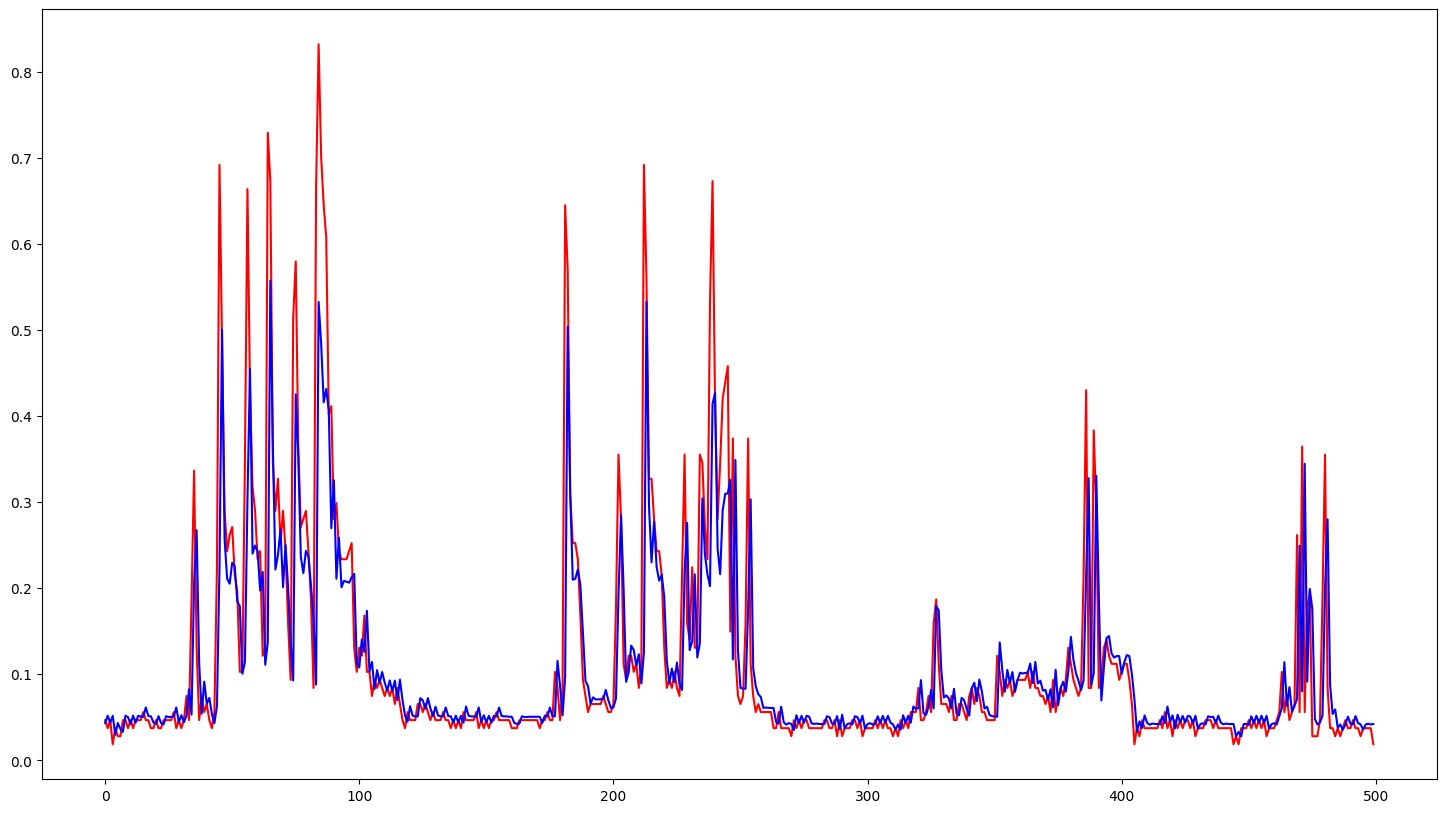

In [17]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r')
plt.plot(mlp_bs.predict(X_test_w[:500,:]),'b')

In [18]:
predictions = mlp_bs.predict(X_test_w)

In [19]:
predictions[:15]

array([0.04343884, 0.05189952, 0.04381503, 0.05176501, 0.02968919,
       0.04344794, 0.03646957, 0.03301633, 0.05196561, 0.0501435 ,
       0.04232821, 0.05189952, 0.04381503, 0.05176501, 0.05087795])

In [20]:
y_test_w[:15]

array([0.04672897, 0.03738318, 0.04672897, 0.01869159, 0.03738318,
       0.02803738, 0.02803738, 0.04672897, 0.04672897, 0.03738318,
       0.04672897, 0.03738318, 0.04672897, 0.04672897, 0.04672897])